## **Download Packages**

In [1]:
!pip install patchify

## **Loading Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf
from tensorflow.keras.layers import Multiply,GlobalAveragePooling1D,MultiHeadAttention,Embedding,Lambda,Dense,Flatten,Conv2D,Dropout, Conv2DTranspose, MaxPooling2D, Input, Activation, Concatenate, UpSampling2D, Resizing,Reshape,Add,LayerNormalization,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.colors as colors
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from patchify import patchify
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2


## **Load Data**

In [3]:
path = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset'

In [12]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 6000, shuffle = False)

Found 5682 files belonging to 2 classes.


In [13]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(5682, 128, 128, 3) (5682,)


In [14]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 128, 128, 3) (2841, 128, 128, 3)


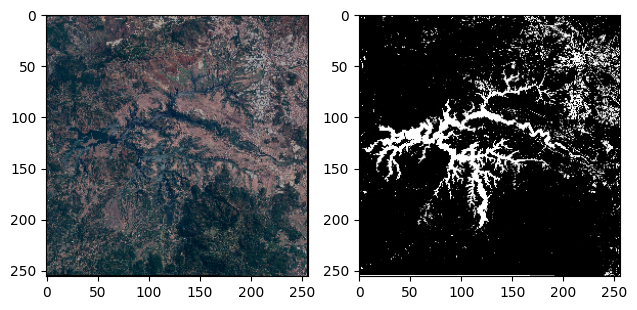

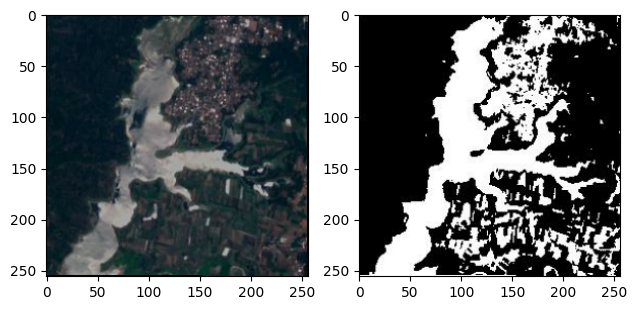

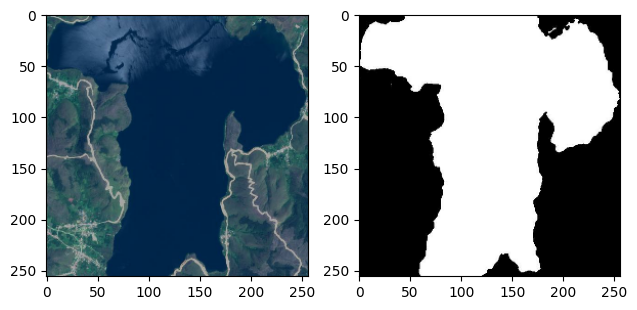

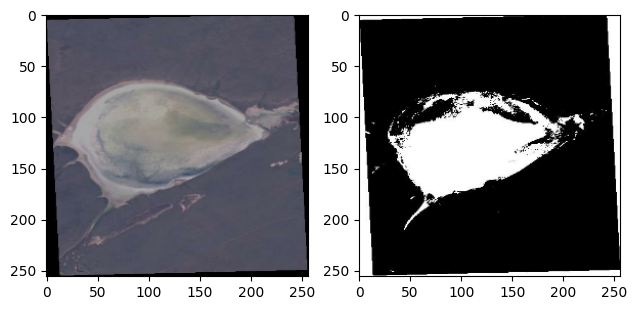

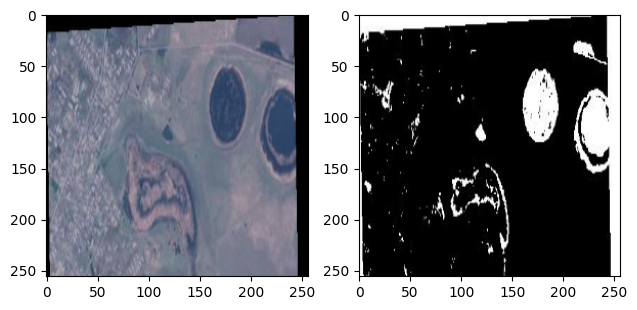

In [9]:
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i])

    plt.tight_layout()
    plt.show()

### **Split Data into Train and Test**

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, masks, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 128, 128, 3) (569, 128, 128, 3)


### **Mask to single Channel**

In [16]:
# Convert masks to single channel (binary)
y_train = (y_train[..., 0] > 0).astype("uint8")  # Assuming the first channel represents the mask
y_test = (y_test[..., 0] > 0).astype("uint8")

# Reshape your target arrays to match the model's output shape
y_train = y_train.reshape((-1, 128, 128, 1))
y_test = y_test.reshape((-1, 128, 128, 1))

print(y_train.shape, y_test.shape)

(2272, 128, 128, 1) (569, 128, 128, 1)


### **Function to plot metrics**

In [18]:
def plot_training_history(history, title):
    # Check if `history` is a dictionary and adapt
    if isinstance(history, dict):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt


### **Early Stopping**

In [19]:
# Early Stopping
c1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

### **Calculate IOU**

In [20]:
def calculate_IOU(y_true, y_pred, threshold = 0.5):
    y_pred = (y_pred > threshold).astype(np.uint8) # Binarize predictions
    intersection = np.sum(y_true * y_pred, axis = (1,2)) # Per image
    union = np.sum(y_true + y_pred, axis = (1,2)) - intersection # Per image
    iou = np.mean(intersection / (union + 1e-6)) # Avoid division by zero
    return iou

def Training_IoU(model, X_train, y_train):
    train_predictions = model.predict(X_train)
    train_predictions = train_predictions.squeeze()  # Shape:(height, width)
    y_train = y_train.squeeze()  # Shape:, height, width)

    train_iou = calculate_IOU(y_train, train_predictions)
    return train_iou

def Testing_IoU (model, X_test, y_test):
    test_predictions = model.predict(X_test)
    test_predictions = test_predictions.squeeze()  # Shape: ( height, width)
    y_test = y_test.squeeze()  # Shape: (batch_size, height, width)

    test_iou = calculate_IOU(y_test, test_predictions)
    return test_iou
    
    

### **Training history**
**IOU**

**Training and Validation Accuracy**

**Training and Validation Loss**

In [21]:
def trained_history(path, trained_model, algo, X_train, y_train, X_test, y_test):
  with open(path,'rb') as file:
    loaded_history = pickle.load(file)
  train_accuracy = loaded_history['accuracy']
  train_loss = loaded_history['loss']

  val_accuracy = loaded_history['val_accuracy']
  val_loss = loaded_history['val_loss']

  data = {
    'Algorithm': [algo[0], algo[1]],
    'Accuracy': [train_accuracy[-1], val_accuracy[-1]],
    'Loss': [train_loss[-1], val_loss[-1]],
    'IOU': [Training_IoU(trained_model,X_train, y_train), Testing_IoU(trained_model,X_test, y_test)]
  }

  df = pd.DataFrame(data)

  return df

### **Plot trained images**

In [22]:
def plot_images(X_test, y_test, unet_masks, unet_attention, selected_indices):
  #cmap = colors.ListedColormap(['gray', 'yellow'])  # Example colors

  for i in selected_indices:
    # Create a figure with 6 subplots
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 6, 1)
    plt.imshow(X_test[i].squeeze())
    plt.title(f"Original Image (Index {i})")
    plt.axis('off')

    # True mask
    plt.subplot(1, 6, 2)
    plt.imshow(y_test[i].squeeze(), cmap='viridis')
    plt.title(f'True Mask (Index {i})')
    plt.axis('off')

    # Predicted mask - U-Net
    plt.subplot(1, 6, 3)
    plt.imshow(unet_masks[i].squeeze(), cmap='viridis') # 'viridis', 'plasma', 'magma'
    plt.title(f'U-Net Mask  ')
    plt.axis('off')

    # Predicted mask - U-Net
    plt.subplot(1, 6, 4)
    plt.imshow(unet_attention[i].squeeze(), cmap='viridis') # 'viridis', 'plasma', 'magma'
    plt.title(f'U-Net Attention Mask')
    plt.axis('off')

  plt.show()

# **UNET**

### **Encoder and Decoder**

In [23]:
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2)(x)
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
    skip_features = tf.keras.layers.Resizing(x.shape[1], x.shape[2])(skip_features)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

### **Model Architecture**

In [24]:
def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape = input_shape)

    s1 = encoder_block(inputs, 32)
    s2 = encoder_block(s1, 64)
    s3 = encoder_block(s2, 128)
    s4 = encoder_block(s3, 256)
    print(s4.shape)
    b1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = "same")(s4) # kernel_initializer = "he_uniform"
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = "same")(b1) #  kernel_initializer = "he_uniform"
    b1 = tf.keras.layers.Activation('relu')(b1)

    s5 = decoder_block(b1, s4, 256)
    s6 = decoder_block(s5, s3, 128)
    s7 = decoder_block(s6, s2, 64)
    s8 = decoder_block(s7, s1, 32)

    outputs = tf.keras.layers.Conv2D(filters = num_classes, kernel_size = (3, 3), padding = "same", activation = "sigmoid")(s8)

    model = tf.keras.models.Model(inputs = [inputs], outputs = [outputs], name = 'U-Net')
    return model

In [25]:
model = unet_model(input_shape = (128, 128, 3), num_classes = 1)
model.summary()

(None, 8, 8, 256)


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ activation_4[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[

 Total params: 7,760,353 (29.60 MB)

 Trainable params: 7,760,353 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
unet_trained_model = load_model("/kaggle/input/unet/tensorflow2/default/1/UNET.keras")

In [28]:
with open('/kaggle/input/unet/tensorflow2/default/1/training_history.pkl', 'rb') as file:
    history = pickle.load(file)

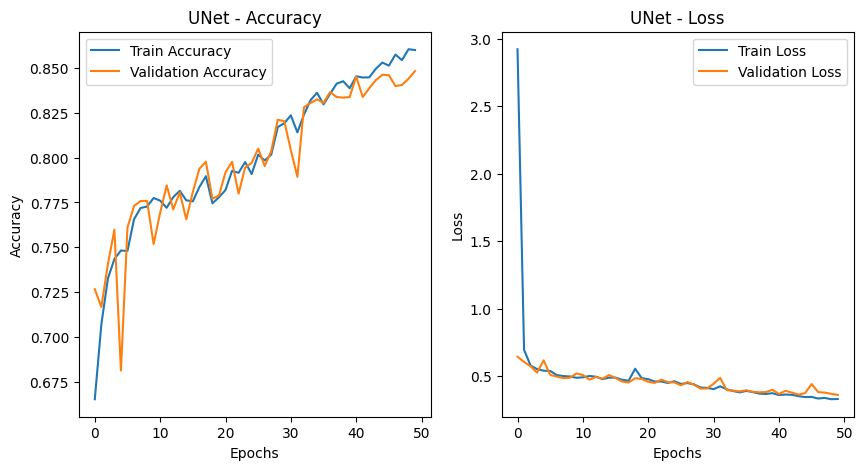

In [29]:
plot_training_history(history, "UNet")

In [31]:
unet_trained_history = trained_history('/kaggle/input/unet/tensorflow2/default/1/training_history.pkl',unet_trained_model, ['U-Net (Training)', 'U-Net (Validation)'], X_train, y_train, X_test, y_test)
print(unet_trained_history)

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
            Algorithm  Accuracy      Loss       IOU
0    U-Net (Training)  0.859886  0.329369  0.662200
1  U-Net (Validation)  0.848209  0.359503  0.626757


In [32]:
unet_masks = unet_trained_model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


# **UNET Attention**

### **Convolution Block helper function**

In [35]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

### **Encoder**

In [36]:
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

### **Attention Block**

In [37]:
def attention_block(g, x, num_filters):
  shape_g = K.int_shape(g)
  shape_x = K.int_shape(x)

  Wg = Conv2D(num_filters, (1, 1), strides=1, padding='same')(g)
  Wg = BatchNormalization()(Wg)

  Wx = Conv2D(num_filters, (1, 1), strides=2, padding='same')(x)
  Wx = BatchNormalization()(Wx)

  concat_xg = Add()([Wg, Wx])
  # relu_act_xg = Activation('relu')(Wg + Wx)
  relu_act_xg = Activation('relu')(concat_xg)
  psi = Conv2D(1, (1, 1), padding='same')(relu_act_xg)
  sig_act_xg = Activation('sigmoid')(psi)
  shape_sig = K.int_shape(sig_act_xg)

  upsample = UpSampling2D(size = (shape_x[1] // shape_sig[1], shape_x[2] // shape_sig[2]))(sig_act_xg)
  out = Multiply()([upsample, x])

  return out


### **Decoder**

In [38]:
# Here g is the decoder output or previous layer and x is the skip connection which conv output of encode before max pooling
def decoder(g, x, num_filters):
  x = attention_block(g, x, num_filters)
  #g = UpSampling2D(interpolation="bilinear")(g)
  g = Conv2DTranspose(num_filters, kernel_size=(2, 2), strides=2, padding='same')(g)
  g = Concatenate()([g, x])
  g = conv_block(g, num_filters)
  return g

### **Model Architecture**

In [39]:
def attention_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape) 

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p3 = encoder_block(p3, 256)

    # Bottleneck
    b1 = conv_block(p3, 512)

    # Decoder
    d1 = decoder(b1, s4, 256)
    d2 = decoder(d1, s3, 128)
    d3 = decoder(d2, s2, 64)
    d4 = decoder(d3, s1, 32)
    
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, output, name='Attention_U-Net')
    return model

In [41]:
unet_att = attention_unet(input_shape = (128, 128, 3), num_classes = 1)
unet_att.summary()

Model: "Attention_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_44       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_44[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_45       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ activation_45[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_46[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ activation_47[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_54[0][0] 

 Total params: 8,038,277 (30.66 MB)

 Trainable params: 8,030,469 (30.63 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [42]:
unet_att.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss = keras.losses.BinaryCrossentropy(), 
    metrics = ["accuracy"]
)

In [43]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=5, min_lr=1e-5, verbose=1
)

In [44]:
unet_att_history = unet_att.fit(X_train, y_train,  epochs=100, validation_data=(X_test, y_test), batch_size=12, callbacks = [lr_scheduler, c1])

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 52s 126ms/step - accuracy: 0.7235 - loss: 0.5496 - val_accuracy: 0.7105 - val_loss: 0.7729 - learning_rate: 0.0010
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7838 - loss: 0.4680 - val_accuracy: 0.7549 - val_loss: 0.5525 - learning_rate: 0.0010
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7969 - loss: 0.4498 - val_accuracy: 0.8037 - val_loss: 0.4267 - learning_rate: 0.0010
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8127 - loss: 0.4201 - val_accuracy: 0.7990 - val_loss: 0.4787 - learning_rate: 0.0010
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8141 - loss: 0.4170 - val_accuracy: 0.7532 - val_loss: 0.6627 - learning_rate: 0.0010
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8104 - loss: 0.4219 - val_accuracy: 0.8346 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8186 -

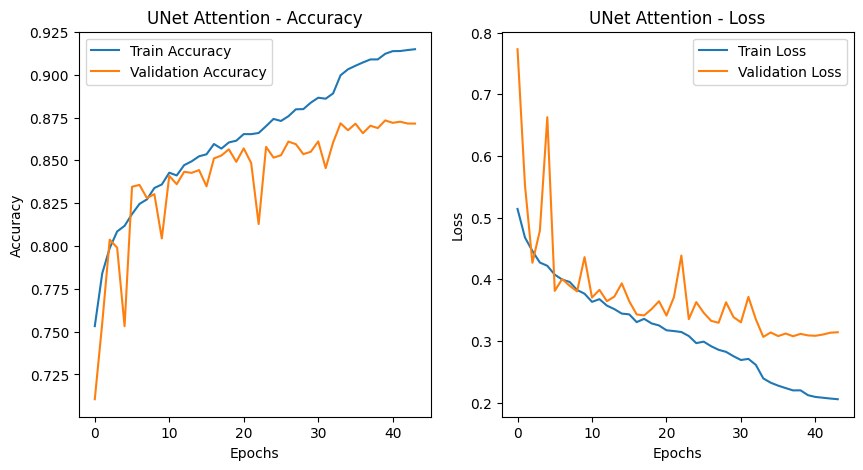

In [45]:
plot_training_history(unet_att_history, "UNet Attention")

In [46]:
unet_att.save("unet_att.keras")

In [47]:
with open('/kaggle/working/training_unet_att_history.pkl', 'wb') as file:
    pickle.dump(unet_att_history.history, file)

In [33]:
#!mv unet_att.keras /kaggle/working/

mv: 'unet_att.keras' and '/kaggle/working/unet_att.keras' are the same file


In [48]:
unet_att_trained_model = load_model("/kaggle/working/unet_att.keras")

In [49]:
unet_att_trained_history = trained_history('/kaggle/working/training_unet_att_history.pkl',unet_att_trained_model, ['U-Net Attention (Training)', 'U-Net Attention (Validation)'], X_train, y_train, X_test, y_test)
print(unet_att_trained_history)

71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step
                      Algorithm  Accuracy      Loss       IOU
0    U-Net Attention (Training)  0.914932  0.205448  0.747117
1  U-Net Attention (Validation)  0.871487  0.314036  0.677502


In [50]:
unet_att_masks = unet_att.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step


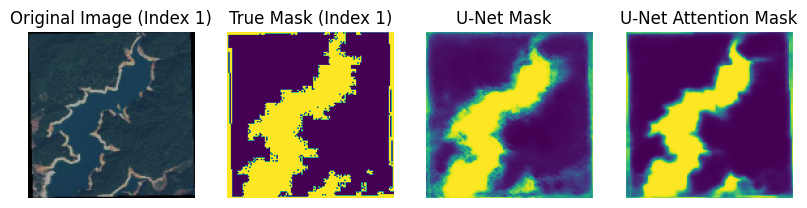

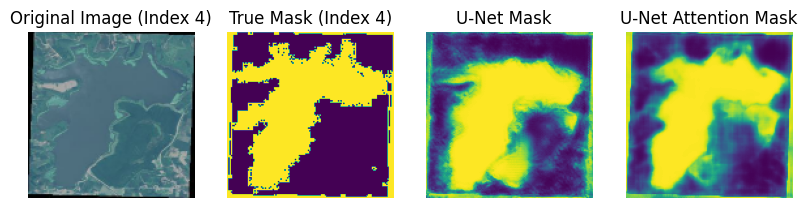

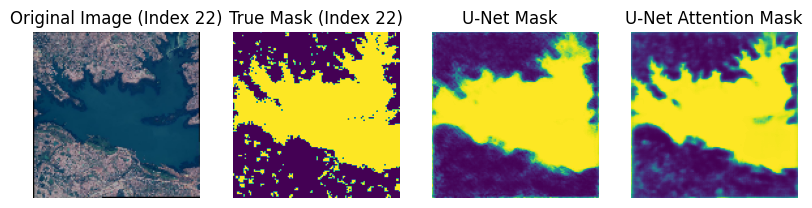

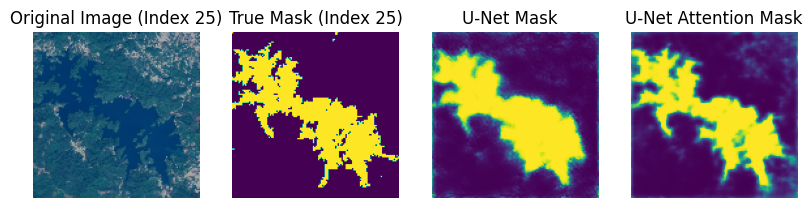

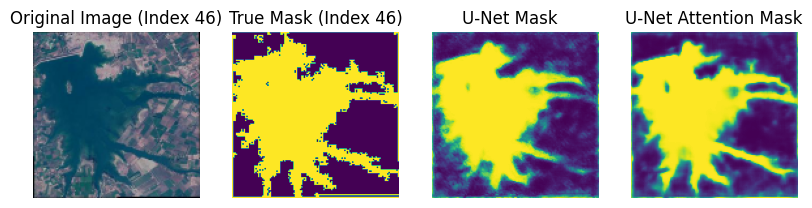

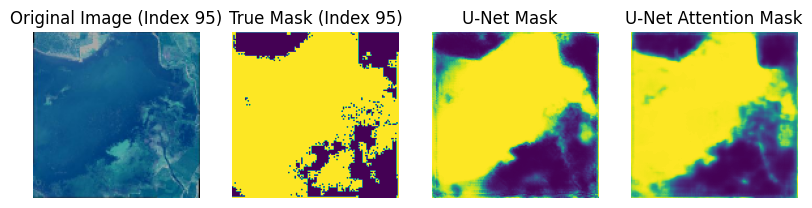

In [64]:
plot_images(X_test, y_test, unet_masks, unet_att_masks,  selected_indices = [1, 4, 22, 25, 46, 95]) # 31